In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

In [2]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import jax_verify
import functools
import optax
from jax import grad, jit
import time
import pickle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# CROWN-Based Verification

# Controller Definitions

In [3]:
def relu_nn(params, inputs, v_max=7, omega_max=np.pi):
    """Neural network controller with ReLU activations.
    """
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout
    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

def linear_controller(params, inputs, v_max=7, omega_max=np.pi):
    """Linear controller.
    """
    W, b = params
    outputs = jnp.dot(inputs, W) + b

    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

def init_network_params(layer_sizes, rng_key):
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]
        key, rng_key = jax.random.split(rng_key)
        bound = jnp.sqrt(6.0 / (in_dim + out_dim))
        weights = jax.random.uniform(key, (in_dim, out_dim), minval=-bound, maxval=bound)
        biases = jnp.zeros(out_dim)
        params.append((weights, biases))
    return params

def init_linear_params(input_dim, output_dim, rng_key):
    weights = jnp.array([[0.01, 0.02],
                        [0.02, 0.01],
                        [0.01, 0.01]])
    biases = jnp.array([0.0, 0.0])
    return (weights, biases)

# Unicycle Model

In [4]:
class UnicycleModel:

    def __init__(self):
        self.delta_t = 0.1
    def dynamics_step(self, xs, ut):
        x, y, theta = xs
        v, omega = ut
        theta_new = theta + omega * self.delta_t
        x_new = x + v * jnp.cos(theta) * self.delta_t
        y_new = y + v * jnp.sin(theta) * self.delta_t

        return jnp.array([x_new, y_new, theta_new])

# Verification Functions

In [5]:
def step_1(xt, params, controller_fn=relu_nn):
    ut = controller_fn(params, xt)
    return dyn.dynamics_step(xt, ut)

def compute_multistep_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0], initial_state_range[:, 1])
    state_bounds = initial_state_bounds
    state_ranges = []

    for i in range(num_steps):
        next_state_bounds = jax_verify.backward_crown_bound_propagation(
            functools.partial(step_fn, params=params), state_bounds)
        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges

def loss_multi_step_reachable_set_volume(reachable_sets):
    volumes = [jnp.prod(set_.upper[:2] - set_.lower[:2]) for set_ in reachable_sets]
    total_volume = jnp.sum(jnp.array(volumes))
    return total_volume

def check_obstacle_collision(state_bounds, obstacles):
    for obs in obstacles:
        obs_x, obs_y, obs_width, obs_height = obs
        obs_lower = jnp.array([obs_x, obs_y])
        obs_upper = jnp.array([obs_x + obs_width, obs_y + obs_height])

        overlap_lower = jnp.maximum(state_bounds.lower[:2], obs_lower)
        overlap_upper = jnp.minimum(state_bounds.upper[:2], obs_upper)
        overlap_size = jnp.maximum(0, overlap_upper - overlap_lower)
        overlap_area = jnp.prod(overlap_size)

        if overlap_area > 0:
            return True, overlap_area

    return False, 0.0

# Loss Functions

In [6]:
def loss_reach_avoid(controller_params, initial_state_bounds, cost_map, obstacles, num_steps, controller_fn=relu_nn):
    step_fn = functools.partial(step_1, controller_fn=controller_fn)

    reachable_set = compute_multistep_reachable_set(
        initial_state_bounds,
        step_fn,
        controller_params,
        num_steps
    )

    loss_value = 0.0
    volume_loss = loss_multi_step_reachable_set_volume(reachable_set)

    goal_zone = np.unravel_index(np.argmin(np.array(cost_map)), cost_map.shape)
    goal_center = jnp.array([goal_zone[1], goal_zone[0]])

    for i, state_bounds in enumerate(reachable_set):
        state_center = (state_bounds.upper + state_bounds.lower) / 2

        # Distance to goal penalty
        distance_to_goal = jnp.linalg.norm(state_center[:2] - goal_center)

        # Goal overlap reward
        overlap_lower_goal = jnp.maximum(state_bounds.lower[:2], goal_center - 0.5)
        overlap_upper_goal = jnp.minimum(state_bounds.upper[:2], goal_center + 0.5)
        overlap_width_goal = jnp.maximum(overlap_upper_goal - overlap_lower_goal, 0)
        overlap_area_goal = jnp.prod(overlap_width_goal)

        # Obstacle penalty
        obstacle_penalty = 0.0
        for obs in obstacles:
            obs_x, obs_y, obs_width, obs_height = obs
            obs_lower = jnp.array([obs_x, obs_y])
            obs_upper = jnp.array([obs_x + obs_width, obs_y + obs_height])

            overlap_lower = jnp.maximum(state_bounds.lower[:2], obs_lower)
            overlap_upper = jnp.minimum(state_bounds.upper[:2], obs_upper)
            overlap_width = jnp.maximum(overlap_upper - overlap_lower, 0)
            overlap_area = jnp.prod(overlap_width)

            obstacle_penalty += 20.0 * overlap_area

        step_loss = 8.0 * distance_to_goal - 15.0 * overlap_area_goal + obstacle_penalty
        loss_value += step_loss

    combined_loss = loss_value + 4 * volume_loss
    return combined_loss

# Training Functions

In [7]:
def train_controller(params, optimizer, initial_state_range, num_epochs, cost_map,
                    obstacles, num_steps, controller_fn=relu_nn,
                    patience=100, threshold=1e-7):

    opt_state = optimizer.init(params)
    best_loss = float('inf')
    best_params = params
    epochs_without_improvement = 0
    loss_history = []

    @jax.jit
    def train_step(params, opt_state):
        loss_value, grads = jax.value_and_grad(
            lambda p: loss_reach_avoid(p, initial_state_range, cost_map, obstacles, num_steps, controller_fn)
        )(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(num_epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        loss_history.append(loss_value)

        if loss_value < best_loss:
            best_loss = loss_value
            best_params = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value}")

        if epochs_without_improvement >= patience:
            if best_loss - loss_value < threshold:
                print(f"Loss plateaued. Stopping training at epoch {epoch}.")
                break

    return best_params, loss_history


# Visualization Functions

In [8]:
def plot_multistep_samples_and_bounds(initial_state_range, step_fn, num_steps, cost_map,
                                     obstacles, bounds_list=None, title=None):
    # Sample initial states
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 3))
    states = [xt]

    # Simulate trajectories
    for _ in range(num_steps):
        xt1 = jax.vmap(step_fn)(xt)
        states.append(xt1)
        xt = xt1

    plt.figure(figsize=(14, 10))

    # Set axis limits
    x_min, x_max = 0, cost_map.shape[1] - 1
    y_min, y_max = 0, cost_map.shape[0] - 1
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    ax = plt.gca()
    ax.set_facecolor('white')

    # Plot obstacles
    for obs in obstacles:
        x, y, width, height = obs
        rect = Rectangle((x, y), width, height,
                        fill=True, facecolor='darkred', edgecolor='black',
                        linewidth=2, alpha=0.7, zorder=5)
        plt.gca().add_patch(rect)
        plt.text(x + width/2, y + height/2, 'OBSTACLE',
                ha='center', va='center',
                color='white', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'),
                zorder=15)

    # Plot reachable sets
    if bounds_list is not None:
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list))
            alpha = 0.5 - (0.3 * i / len(bounds_list))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            plt.gca().add_patch(rect)

    # Plot trajectories
    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)
    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)
    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    for i, state in enumerate(states):
        color = distinct_colors[i % len(distinct_colors)]
        plt.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   label=f'Step {i}' if i % 3 == 0 or i == len(states)-1 else None,
                   zorder=10,
                   edgecolors='black', linewidths=0.3)

    # Plot initial state region
    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                        init_width, init_height,
                        fill=True, facecolor='red', edgecolor='black',
                        linewidth=2, alpha=0.3, zorder=5)
    plt.gca().add_patch(init_rect)
    plt.text(init_x_mid, init_y_mid, 'START',
            ha='center', va='center',
            color='white', fontweight='bold', fontsize=18,
            bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
            zorder=15)

    # Plot goal
    goal_zone = np.unravel_index(np.argmin(cost_map), cost_map.shape)
    goal_x, goal_y = goal_zone[1], goal_zone[0]
    plt.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
              edgecolor='black', linewidth=1.5, zorder=20)
    plt.text(goal_x, goal_y - 0.5, 'GOAL',
            ha='center', va='center',
            color='black', fontweight='bold', fontsize=18,
            bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
            zorder=20)

    # Format plot
    plt.xlabel('X Position', fontsize=20)
    plt.ylabel('Y Position', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

    if title:
        plt.title(title, fontsize=20, pad=20)
    else:
        plt.title('Unicycle Navigation with Verification-Guided Control', fontsize=20, pad=20)

    plt.tight_layout()
    filename = title.lower().replace(' ', '_') + '.png' if title else 'unicycle_navigation.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_loss_history(loss_history, title=None):
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, color='#1f77b4', linewidth=2, alpha=0.8)

    # Add moving average
    window_size = min(50, len(loss_history) // 10)
    if window_size > 0:
        smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(loss_history)), smoothed_loss,
                color='#ff7f0e', linewidth=3, label=f'Moving Avg (window={window_size})')

    # Annotate initial and final loss values
    plt.annotate(f'Initial loss: {loss_history[0]:.2f}',
                xy=(0, loss_history[0]),
                xytext=(len(loss_history)*0.05, loss_history[0]*1.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    plt.annotate(f'Final loss: {loss_history[-1]:.2f}',
                xy=(len(loss_history)-1, loss_history[-1]),
                xytext=(len(loss_history)*0.8, loss_history[-1]*1.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    # Format plot
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    if title:
        plt.title(title, fontsize=16, pad=20)
    else:
        plt.title('Training Loss Over Time', fontsize=16, pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Use log scale for loss if appropriate
    if min(loss_history) > 0:
        plt.yscale('log')
        plt.title((title + ' (Log Scale)') if title else 'Training Loss Over Time (Log Scale)',
                 fontsize=16, pad=20)

    plt.tight_layout()
    filename = (title.lower().replace(' ', '_') if title else 'training_loss') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# File I/O Functions

In [9]:
def save_trained_params(params, filename='trained_params.pkl', controller_type='neural_network'):
    if controller_type == 'neural_network':
        numpy_params = []
        for weights, biases in params:
            numpy_weights = np.array(weights)
            numpy_biases = np.array(biases)
            numpy_params.append((numpy_weights, numpy_biases))
    else:  # linear
        numpy_params = (np.array(params[0]), np.array(params[1]))

    with open(filename, 'wb') as f:
        pickle.dump(numpy_params, f)

    print(f"Trained parameters saved to {filename}")

def load_trained_params(filename='trained_params.pkl', controller_type='neural_network'):
    with open(filename, 'rb') as f:
        numpy_params = pickle.load(f)

    if controller_type == 'neural_network':
        jax_params = []
        for weights, biases in numpy_params:
            jax_weights = jnp.array(weights)
            jax_biases = jnp.array(biases)
            jax_params.append((jax_weights, jax_biases))
    else:  # linear
        jax_params = (jnp.array(numpy_params[0]), jnp.array(numpy_params[1]))

    print(f"Trained parameters loaded from {filename}")
    return jax_params


# Main Experiment Functions

In [10]:
def run_nn_controller_experiment():
    """Run experiment with neural network controller."""
    print("\n=== Neural Network Controller Experiment ===\n")

    dyn = UnicycleModel()
    rng_key = jax.random.PRNGKey(0)
    layer_sizes = [3, 16, 32, 16, 2]
    params = init_network_params(layer_sizes, rng_key)

    initial_state_range = np.array([
        [0, 1],       # x position
        [0, 1],       # y position
        [0, np.pi/6]  # theta (orientation)
    ])

    obstacles = [
        [2.0, 4.0, 1.0, 1.0],
        [7.75, 1.75, 1.0, 1.0]
    ]

    grid_size = 13
    x = np.linspace(0, 12, grid_size)
    y = np.linspace(0, 12, grid_size)
    X, Y = np.meshgrid(x, y)
    cost_map = (X/12 - 1)**2 + (Y/12 - 1)**2

    for obs in obstacles:
        obs_x, obs_y, obs_width, obs_height = obs
        obs_mask = (X >= obs_x) & (X < obs_x + obs_width) & (Y >= obs_y) & (Y < obs_y + obs_height)
        cost_map[obs_mask] = 10.0

    goal_zone = (7, 7)
    cost_map[goal_zone] = 0
    cost_map = jnp.array(cost_map)

    num_steps = 24
    learning_rate = 0.0001
    optimizer = optax.adam(learning_rate)
    num_epochs = 20000

    print("Starting training with obstacles...")
    trained_params, loss_history = train_controller(
        params, optimizer, jnp.array(initial_state_range),
        num_epochs, cost_map, obstacles, num_steps,
        controller_fn=relu_nn
    )
    print("Training completed.")

    # save_trained_params(trained_params, 'crown_nn.pkl', 'neural_network')

    print("Computing reachable sets using trained controller...")
    output_ranges = compute_multistep_reachable_set(
        initial_state_range,
        functools.partial(step_1, controller_fn=relu_nn),
        trained_params,
        num_steps
    )

    plot_multistep_samples_and_bounds(
        initial_state_range,
        functools.partial(step_1, params=trained_params, controller_fn=relu_nn),
        num_steps,
        cost_map,
        obstacles,
        output_ranges,
        title="Neural Network Controller with CROWN Verification"
    )

    plot_loss_history(loss_history, "NN Controller Training Loss")

    return trained_params, output_ranges

def run_linear_controller_experiment():
    """Run experiment with linear controller."""
    print("\n=== Linear Controller Experiment ===\n")

    dyn = UnicycleModel()
    rng_key = jax.random.PRNGKey(0)
    params = init_linear_params(3, 2, rng_key)

    initial_state_range = np.array([
        [0, 1],       # x position
        [0, 1],       # y position
        [0, np.pi/6]  # theta (orientation)
    ])

    obstacles = [
        [2.0, 4.0, 1.0, 1.0],
        [7.75, 1.75, 1.0, 1.0]
    ]
    obstacles_array = jnp.array(obstacles)

    grid_size = 13
    x = np.linspace(0, 12, grid_size)
    y = np.linspace(0, 12, grid_size)
    X, Y = np.meshgrid(x, y)
    cost_map = (X/12 - 1)**2 + (Y/12 - 1)**2

    for obs in obstacles:
        obs_x, obs_y, obs_width, obs_height = obs
        obs_mask = (X >= obs_x) & (X < obs_x + obs_width) & (Y >= obs_y) & (Y < obs_y + obs_height)
        cost_map[obs_mask] = 10.0

    goal_zone = (7, 7)
    cost_map[goal_zone] = 0
    cost_map = jnp.array(cost_map)

    num_steps = 20
    learning_rate = 0.0001
    optimizer = optax.adam(learning_rate)
    num_epochs = 20000

    print("Starting training with obstacles...")
    trained_params, loss_history = train_controller(
        params, optimizer, jnp.array(initial_state_range),
        num_epochs, cost_map, obstacles, num_steps,
        controller_fn=linear_controller
    )
    print("Training completed.")

    # save_trained_params(trained_params, 'crown_linear.pkl', 'linear')

    print("Computing reachable sets using trained controller...")
    output_ranges = compute_multistep_reachable_set(
        initial_state_range,
        functools.partial(step_1, controller_fn=linear_controller),
        trained_params,
        num_steps
    )

    plot_multistep_samples_and_bounds(
        initial_state_range,
        functools.partial(step_1, params=trained_params, controller_fn=linear_controller),
        num_steps,
        cost_map,
        obstacles,
        output_ranges,
        title="Linear Controller with CROWN Verification"
    )

    plot_loss_history(loss_history, "Linear Controller Training Loss")

    return trained_params, output_ranges

# Main Execution

=== Verification-Based Controller Comparison ===
This notebook compares different controllers for unicycle navigation
with formal safety guarantees using CROWN verification.

Attempting to load pre-trained controllers...
Pre-trained controllers not found. Training new controllers...

=== Neural Network Controller Experiment ===

Starting training with obstacles...
Epoch 0, Loss: 4765624.5
Epoch 100, Loss: 4014075.25
Epoch 200, Loss: 3487487.25
Epoch 300, Loss: 3358945.5
Epoch 400, Loss: 3118057.5
Epoch 500, Loss: 2919075.5
Epoch 600, Loss: 2052693.375
Epoch 700, Loss: 1161225.875
Epoch 800, Loss: 47307.296875
Epoch 900, Loss: 2660.93115234375
Epoch 1000, Loss: 2263.489013671875
Epoch 1100, Loss: 2142.33251953125
Epoch 1200, Loss: 2086.760986328125
Epoch 1300, Loss: 2053.155029296875
Epoch 1400, Loss: 2027.05615234375
Epoch 1500, Loss: 2007.095947265625
Epoch 1600, Loss: 1992.574462890625
Epoch 1700, Loss: 1980.7869873046875
Epoch 1800, Loss: 1968.1199951171875
Epoch 1900, Loss: 1958.57

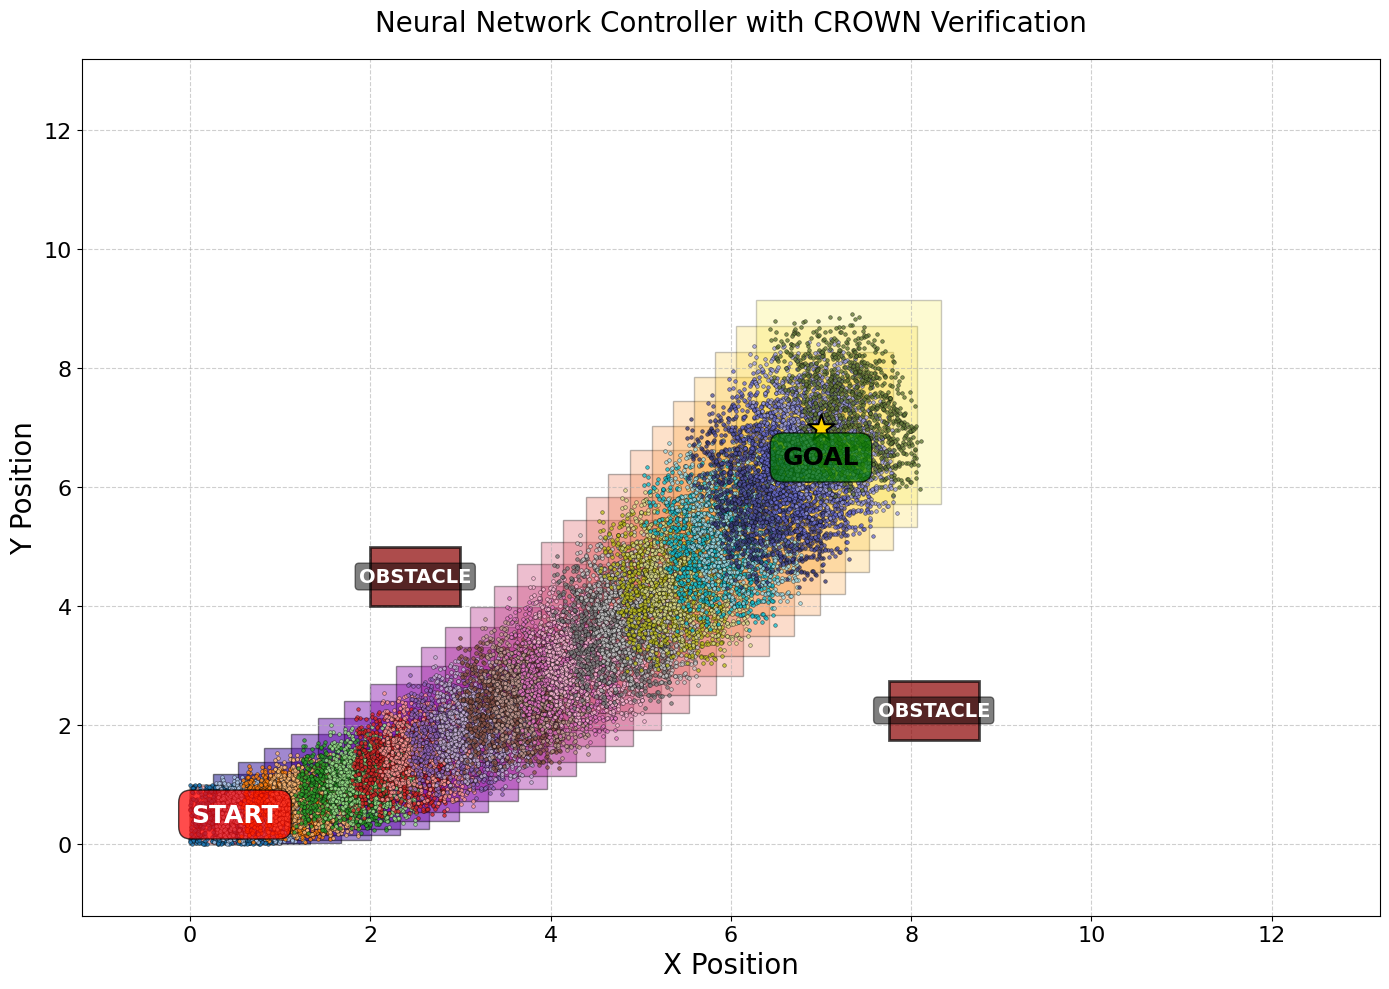

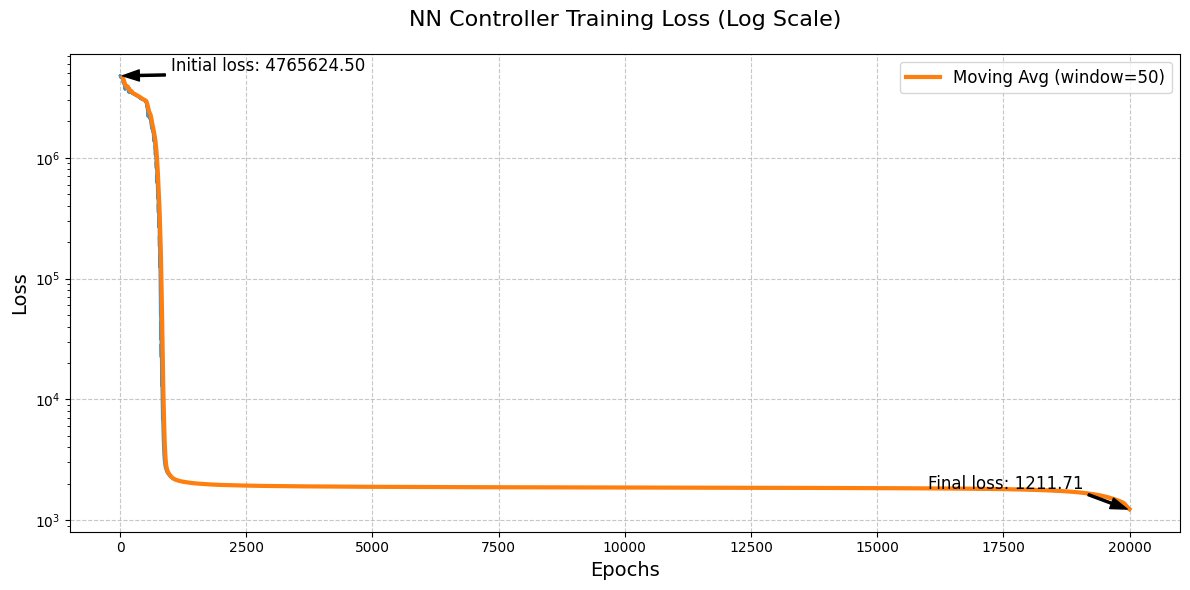


=== Linear Controller Experiment ===

Starting training with obstacles...
Epoch 0, Loss: 1552.2490234375
Epoch 100, Loss: 1550.1903076171875
Epoch 200, Loss: 1548.74462890625
Epoch 300, Loss: 1547.6409912109375
Epoch 400, Loss: 1546.5289306640625
Epoch 500, Loss: 1545.38818359375
Epoch 600, Loss: 1544.2176513671875
Epoch 700, Loss: 1543.012451171875
Epoch 800, Loss: 1541.7586669921875
Epoch 900, Loss: 1540.446044921875
Epoch 1000, Loss: 1539.0703125
Epoch 1100, Loss: 1537.6781005859375
Epoch 1200, Loss: 1536.2540283203125
Epoch 1300, Loss: 1534.7977294921875
Epoch 1400, Loss: 1533.307373046875
Epoch 1500, Loss: 1531.7840576171875
Epoch 1600, Loss: 1530.2261962890625
Epoch 1700, Loss: 1528.634521484375
Epoch 1800, Loss: 1527.00390625
Epoch 1900, Loss: 1525.337890625
Epoch 2000, Loss: 1523.6390380859375
Epoch 2100, Loss: 1521.9014892578125
Epoch 2200, Loss: 1520.133056640625
Epoch 2300, Loss: 1518.3302001953125
Epoch 2400, Loss: 1516.4979248046875
Epoch 2500, Loss: 1514.637451171875
Epo

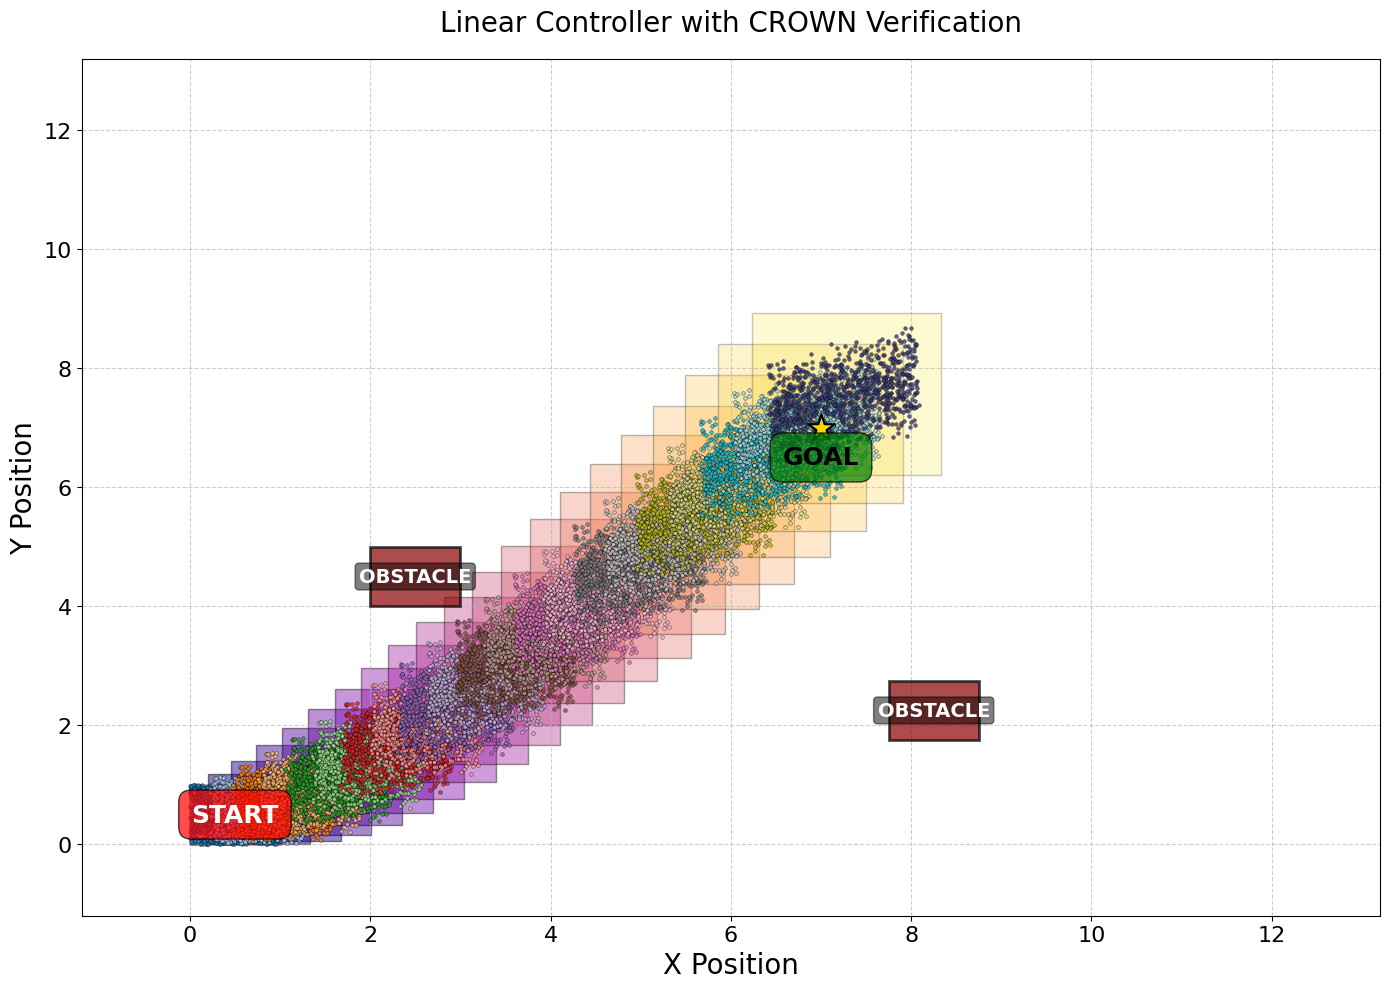

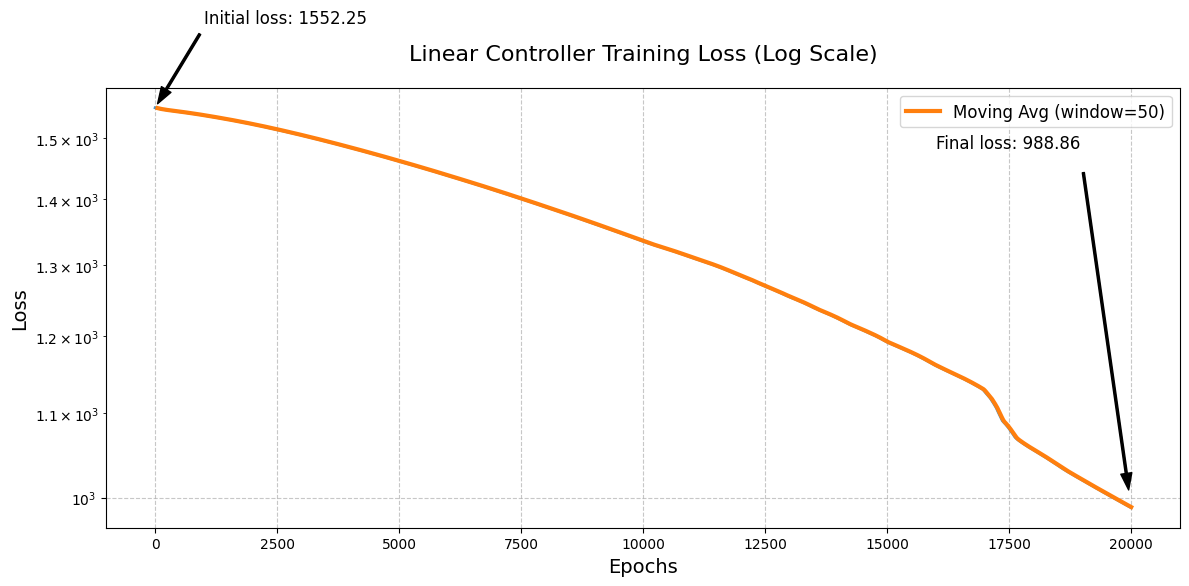

In [11]:
dyn = UnicycleModel()

# Run experiments
print("=== Verification-Based Controller Comparison ===")
print("This notebook compares different controllers for unicycle navigation")
print("with formal safety guarantees using CROWN verification.\n")

try:
    print("Attempting to load pre-trained controllers...")
    nn_params = load_trained_params('crown_nn.pkl', 'neural_network')
    linear_params = load_trained_params('crown_linear.pkl', 'linear')

    initial_state_range = np.array([
        [0, 1],       # x position
        [0, 1],       # y position
        [0, np.pi/6]  # theta (orientation)
    ])

    print("Computing reachable sets for loaded controllers...")
    nn_ranges = compute_multistep_reachable_set(
        initial_state_range,
        functools.partial(step_1, controller_fn=relu_nn),
        nn_params,
        24  # num_steps for NN
    )

    linear_ranges = compute_multistep_reachable_set(
        initial_state_range,
        functools.partial(step_1, controller_fn=linear_controller),
        linear_params,
        20  # num_steps for linear
    )

    print("Controllers and reachable sets loaded successfully!")

except FileNotFoundError:
    print("Pre-trained controllers not found. Training new controllers...")
    nn_params, nn_ranges = run_nn_controller_experiment()
    linear_params, linear_ranges = run_linear_controller_experiment()

# Gradient-Based Verification

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Verification Support Classes

In [13]:
class RectangularBound:

    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

# Controller Definitions


In [14]:
class LinearController:

    def __init__(self, v_max=7, omega_max=np.pi):
        self.v_max = v_max
        self.omega_max = omega_max

        rng = np.random.RandomState(0)
        scale = 0.1
        bound = scale * np.sqrt(6.0 / 5)
        self.params = rng.uniform(-bound, bound, size=6)

    def __call__(self, state):
        norm_state = state / np.array([10.0, 10.0, np.pi])

        v_raw = np.dot(self.params[:3], norm_state)
        omega_raw = np.dot(self.params[3:], norm_state)

        v = np.clip(v_raw, -self.v_max, self.v_max)
        omega = np.clip(omega_raw, -self.omega_max, self.omega_max)

        return np.array([v, omega])

class NeuralNetController:
    def __init__(self, v_max=7, omega_max=np.pi):
        self.v_max = v_max
        self.omega_max = omega_max

        rng = np.random.RandomState(0)
        layer_sizes = [3, 16, 32, 16, 2]
        self.params = []

        for i in range(1, len(layer_sizes)):
            in_dim = layer_sizes[i - 1]
            out_dim = layer_sizes[i]
            bound = np.sqrt(6.0 / (in_dim + out_dim))
            W = rng.uniform(-bound, bound, (in_dim, out_dim))
            b = np.zeros(out_dim)
            self.params.append((W, b))

    def __call__(self, state):
        norm_state = state / np.array([10.0, 10.0, np.pi])

        x = norm_state
        for W, b in self.params[:-1]:
            z = np.dot(x, W) + b
            x = np.maximum(z, 0)

        W_final, b_final = self.params[-1]
        outputs = np.dot(x, W_final) + b_final

        v = np.clip(outputs[0], -self.v_max, self.v_max)
        omega = np.clip(outputs[1], -self.omega_max, self.omega_max)

        return np.array([v, omega])

    def get_params_flattened(self):
        flattened = []
        for W, b in self.params:
            flattened.extend(W.flatten())
            flattened.extend(b.flatten())
        return np.array(flattened)

    def set_params_flattened(self, flattened_params):
        idx = 0
        layer_sizes = [3, 16, 32, 16, 2]
        self.params = []

        for i in range(1, len(layer_sizes)):
            in_dim = layer_sizes[i - 1]
            out_dim = layer_sizes[i]

            W_size = in_dim * out_dim
            W = flattened_params[idx:idx + W_size].reshape(in_dim, out_dim)
            idx += W_size

            b_size = out_dim
            b = flattened_params[idx:idx + b_size]
            idx += b_size

            self.params.append((W, b))

# Unicycle Model

In [15]:
class UnicycleModel:
    """Unicycle dynamics model."""

    def __init__(self):
        self.delta_t = 0.1  # Time step

    def dynamics_step(self, state, control):
        """
        Single step of unicycle dynamics.

        Args:
            state: State vector [x, y, theta]
            control: Control input [v, omega]

        Returns:
            Next state
        """
        x, y, theta = state
        v, omega = control

        theta_new = theta + omega * self.delta_t

        x_new = x + v * np.cos(theta) * self.delta_t
        y_new = y + v * np.sin(theta) * self.delta_t

        return np.array([x_new, y_new, theta_new])

# Verification Functions

In [16]:
def step_fn(state, controller):
    control = controller(state)
    dyn = UnicycleModel()
    return dyn.dynamics_step(state, control)

def compute_multistep_reachable_set(initial_state_range, controller, num_steps):
    initial_state_bounds = RectangularBound(
        initial_state_range[:, 0].copy(),
        initial_state_range[:, 1].copy()
    )
    state_bounds = initial_state_bounds
    state_ranges = []

    for _ in range(num_steps):
        current_bounds = state_bounds
        next_lower = np.full(3, float('inf'))
        next_upper = np.full(3, -float('inf'))

        corners_x = [current_bounds.lower[0], current_bounds.upper[0]]
        corners_y = [current_bounds.lower[1], current_bounds.upper[1]]
        corners_theta = [current_bounds.lower[2], current_bounds.upper[2]]

        for x in corners_x:
            for y in corners_y:
                for theta in corners_theta:
                    state = np.array([x, y, theta])
                    next_state = step_fn(state, controller)
                    next_lower = np.minimum(next_lower, next_state)
                    next_upper = np.maximum(next_upper, next_state)

        state_bounds = RectangularBound(next_lower, next_upper)
        state_ranges.append(state_bounds)

    return state_ranges

# Loss Function

In [17]:
def compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps):
    reachable_sets = compute_multistep_reachable_set(
        initial_state_range,
        controller,
        num_steps
    )

    goal_zone = np.unravel_index(np.argmin(cost_map), cost_map.shape)
    goal_center = np.array([float(goal_zone[1]), float(goal_zone[0])])

    total_loss = 0
    for t, state_bounds in enumerate(reachable_sets):
        state_center = (state_bounds.upper + state_bounds.lower) / 2

        # Goal-reaching term (weighted by time)
        time_weight = (t + 1) / len(reachable_sets)
        distance_to_goal = np.linalg.norm(state_center[:2] - goal_center)
        goal_loss = 15.0 * time_weight * distance_to_goal

        # Obstacle avoidance term
        danger_loss = 0
        for obstacle in obstacles:
            obs_x, obs_y, obs_width, obs_height = obstacle

            # Compute overlap with obstacle
            overlap_lower = np.maximum(state_bounds.lower[:2], [obs_x, obs_y])
            overlap_upper = np.minimum(state_bounds.upper[:2], [obs_x + obs_width, obs_y + obs_height])
            overlap_width = np.maximum(overlap_upper - overlap_lower, 0.0)
            overlap_area = np.prod(overlap_width)

            danger_loss += 20.0 * overlap_area

        # Goal overlap reward
        overlap_lower_goal = np.maximum(state_bounds.lower[:2], goal_center - 0.5)
        overlap_upper_goal = np.minimum(state_bounds.upper[:2], goal_center + 0.5)
        overlap_width_goal = np.maximum(overlap_upper_goal - overlap_lower_goal, 0.0)
        goal_reward = 20.0 * np.prod(overlap_width_goal)

        # Parameter regularization
        if isinstance(controller, LinearController):
            param_penalty = 0.1 * np.sum(controller.params**2)
        else:  # Neural network
            params = controller.get_params_flattened()
            param_penalty = 0.1 * np.sum(params**2)

        step_loss = goal_loss + danger_loss - goal_reward + param_penalty
        total_loss += step_loss

    volume_loss = 0.5 * sum(np.prod(set_.upper[:2] - set_.lower[:2])
                           for set_ in reachable_sets)

    return total_loss + volume_loss

# Numerical Gradient Functions

In [18]:
def compute_numerical_gradient(controller, initial_state_range, cost_map, obstacles, num_steps, epsilon=1e-4):
    if isinstance(controller, LinearController):
        grad = np.zeros_like(controller.params)

        for i in range(len(controller.params)):
            param_orig = controller.params[i]

            controller.params[i] += epsilon
            loss_plus = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)

            controller.params[i] -= 2 * epsilon
            loss_minus = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)

            controller.params[i] += epsilon
            grad[i] = (loss_plus - loss_minus) / (2 * epsilon)

        return grad
    else:
        params = controller.get_params_flattened()
        grad = np.zeros_like(params)

        for i in range(len(params)):
            param_orig = params[i]

            params[i] = param_orig + epsilon
            controller.set_params_flattened(params)
            loss_plus = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)

            params[i] = param_orig - epsilon
            controller.set_params_flattened(params)
            loss_minus = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)

            params[i] = param_orig
            controller.set_params_flattened(params)
            grad[i] = (loss_plus - loss_minus) / (2 * epsilon)

        return grad

# Training Functions

In [19]:
def train_controller(controller, initial_state_range, cost_map, obstacles, num_steps,
                     num_epochs=2000, patience=100, threshold=1e-7):
    if isinstance(controller, LinearController):
        best_loss = float('inf')
        best_params = controller.params.copy()
    else:
        best_loss = float('inf')
        best_params = controller.get_params_flattened().copy()

    loss_history = []
    learning_rate = 0.001
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        grad = compute_numerical_gradient(controller, initial_state_range, cost_map, obstacles, num_steps)

        grad_norm = np.linalg.norm(grad)
        if grad_norm > 1.0:
            grad = grad / grad_norm

        if isinstance(controller, LinearController):
            controller.params -= learning_rate * grad
            loss = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)
        else:
            params = controller.get_params_flattened()
            params -= learning_rate * grad
            controller.set_params_flattened(params)
            loss = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)

        loss_history.append(loss)

        if loss < best_loss:
            if isinstance(controller, LinearController):
                best_loss = loss
                best_params = controller.params.copy()
            else:
                best_loss = loss
                best_params = controller.get_params_flattened().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            if best_loss - loss < threshold:
                print(f"Loss plateaued. Stopping training at epoch {epoch}.")
                break

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    if isinstance(controller, LinearController):
        controller.params = best_params
    else:
        controller.set_params_flattened(best_params)

    return controller, loss_history

# Visualization Functions

In [20]:
def plot_multistep_samples_and_bounds(initial_state_range, controller, num_steps, cost_map,
                                     obstacles, bounds_list=None, title=None):
    # Sample initial states
    xt = np.random.uniform(
        low=initial_state_range[:, 0],
        high=initial_state_range[:, 1],
        size=(1000, 3)
    )
    states = [xt]

    # Simulate trajectories
    for _ in range(num_steps):
        next_states = np.zeros_like(xt)
        for i, x in enumerate(xt):
            next_states[i] = step_fn(x, controller)
        states.append(next_states)
        xt = next_states

    # Create figure
    plt.figure(figsize=(14, 10))

    # Set axis limits
    x_min, x_max = 0, cost_map.shape[1] - 1
    y_min, y_max = 0, cost_map.shape[0] - 1
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    ax = plt.gca()
    ax.set_facecolor('white')

    # Plot obstacles
    for obs in obstacles:
        x, y, width, height = obs
        rect = Rectangle((x, y), width, height,
                         fill=True, facecolor='darkred', edgecolor='black',
                         linewidth=2, alpha=0.7, zorder=5)
        plt.gca().add_patch(rect)
        plt.text(x + width/2, y + height/2, 'OBSTACLE',
                ha='center', va='center',
                color='white', fontweight='bold', fontsize=14,
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'),
                zorder=15)

    # Plot reachable sets
    if bounds_list is not None:
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list))
            alpha = 0.5 - (0.3 * i / len(bounds_list))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            plt.gca().add_patch(rect)

    # Plot trajectories
    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)
    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)
    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    for i, state in enumerate(states):
        color = distinct_colors[i % len(distinct_colors)]
        plt.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   label=f'Step {i}' if i % 3 == 0 or i == len(states)-1 else None,
                   zorder=10,
                   edgecolors='black', linewidths=0.3)

    # Plot initial state region
    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                         init_width, init_height,
                         fill=True, facecolor='red', edgecolor='black',
                         linewidth=2, alpha=0.3, zorder=5)
    plt.gca().add_patch(init_rect)
    plt.text(init_x_mid, init_y_mid, 'START',
             ha='center', va='center',
             color='white', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=15)

    # Plot goal
    goal_zone = np.unravel_index(np.argmin(cost_map), cost_map.shape)
    goal_x, goal_y = goal_zone[1], goal_zone[0]
    plt.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
               edgecolor='black', linewidth=1.5, zorder=20)
    plt.text(goal_x, goal_y - 0.5, 'GOAL',
             ha='center', va='center',
             color='black', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=20)

    # Add legend
    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=plt.cm.plasma(0.5), edgecolor='black', alpha=0.5, label='Reachable Sets'),
        Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', alpha=0.3, label='Initial State Region'),
        Rectangle((0, 0), 1, 1, facecolor='darkred', edgecolor='black', alpha=0.7, label='Obstacles'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=18, label='Goal Position')
    ]

    ncol = min(3, max(1, len(legend_elements) // 5))
    plt.legend(handles=legend_elements, loc='upper left', fontsize=16, ncol=ncol,
              framealpha=0.8, edgecolor='black')

    # Format plot
    plt.xlabel('X Position', fontsize=20)
    plt.ylabel('Y Position', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

    if title:
        plt.title(title, fontsize=20, pad=20)
    else:
        plt.title('Unicycle Navigation with Gradient-Based Verification', fontsize=20, pad=20)

    controller_type = "neural_net" if isinstance(controller, NeuralNetController) else "linear"
    filename = f'unicycle_navigation_gradient_{controller_type}.png'
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_loss_history(loss_history, title=None):
    """
    Plot training loss history.

    Args:
        loss_history: List of loss values
        title: Plot title (optional)
    """
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, color='#1f77b4', linewidth=2, alpha=0.8)

    # Add moving average
    window_size = min(50, len(loss_history) // 10)
    if window_size > 0:
        smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(loss_history)), smoothed_loss,
                color='#ff7f0e', linewidth=3, label=f'Moving Avg (window={window_size})')

    # Annotate initial and final loss values
    plt.annotate(f'Initial loss: {loss_history[0]:.2f}',
                xy=(0, loss_history[0]),
                xytext=(len(loss_history)*0.05, loss_history[0]*1.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    plt.annotate(f'Final loss: {loss_history[-1]:.2f}',
                xy=(len(loss_history)-1, loss_history[-1]),
                xytext=(len(loss_history)*0.8, loss_history[-1]*1.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    # Format plot
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    if title:
        plt.title(title, fontsize=16, pad=20)
    else:
        plt.title('Training Loss Over Time', fontsize=16, pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Use log scale for loss if appropriate
    if min(loss_history) > 0:
        plt.yscale('log')
        plt.title((title + ' (Log Scale)') if title else 'Training Loss Over Time (Log Scale)',
                 fontsize=16, pad=20)

    plt.tight_layout()
    plt.savefig('gradient_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()


# File I/O Functions

In [21]:
def save_controller(controller, filename):
    if isinstance(controller, LinearController):
        with open(filename, 'wb') as f:
            pickle.dump(controller.params, f)
    else:  # Neural network
        with open(filename, 'wb') as f:
            pickle.dump(controller.get_params_flattened(), f)

    print(f"Controller parameters saved to {filename}")

def load_controller(filename, controller_type='linear'):
    with open(filename, 'rb') as f:
        params = pickle.load(f)

    if controller_type == 'linear':
        controller = LinearController()
        controller.params = params
    else:  # Neural network
        controller = NeuralNetController()
        controller.set_params_flattened(params)

    print(f"Controller parameters loaded from {filename}")
    return controller

# Experiment Functions

In [22]:
def run_linear_experiment():
    print("\n=== Linear Controller Experiment (Gradient-Based) ===\n")

    initial_state_range = np.array([
        [0, 1],       # x position
        [0, 1],       # y position
        [0, np.pi/6]  # theta (orientation)
    ])

    obstacles = [
        [2.0, 4.0, 1.0, 1.0],
        [7.75, 1.75, 1.0, 1.0]
    ]
    grid_size = 13
    cost_map = np.zeros((grid_size, grid_size))
    goal_zone = (7, 7)
    cost_map[goal_zone] = -1

    num_steps = 20
    num_epochs = 5000

    print("Starting training...")
    controller = LinearController()
    initial_loss = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)
    print(f"Initial loss: {initial_loss:.4f}")

    trained_controller, loss_history = train_controller(
        controller, initial_state_range, cost_map, obstacles, num_steps, num_epochs
    )
    print("Training completed.")

    save_controller(trained_controller, 'gradient_linear.pkl')

    print("Computing reachable sets using trained controller...")
    output_ranges = compute_multistep_reachable_set(
        initial_state_range, trained_controller, num_steps
    )

    print("Plotting results...")
    plot_multistep_samples_and_bounds(
        initial_state_range, trained_controller, num_steps, cost_map, obstacles,
        bounds_list=output_ranges,
        title="Linear Controller with Gradient-Based Verification"
    )

    plot_loss_history(
        loss_history,
        title="Linear Controller Training Loss (Gradient-Based)"
    )

    return trained_controller, output_ranges

def run_neural_net_experiment():
    print("\n=== Neural Network Controller Experiment (Gradient-Based) ===\n")

    initial_state_range = np.array([
        [0, 1],       # x position
        [0, 1],       # y position
        [0, np.pi/6]  # theta (orientation)
    ])

    obstacles = [
        [2.0, 4.0, 1.0, 1.0],
        [7.75, 1.75, 1.0, 1.0]
    ]

    grid_size = 13
    cost_map = np.zeros((grid_size, grid_size))
    goal_zone = (7, 7)
    cost_map[goal_zone] = -1

    num_steps = 23
    num_epochs = 2000

    print("Starting training...")
    controller = NeuralNetController()
    initial_loss = compute_loss(controller, initial_state_range, cost_map, obstacles, num_steps)
    print(f"Initial loss: {initial_loss:.4f}")

    trained_controller, loss_history = train_controller(
        controller, initial_state_range, cost_map, obstacles, num_steps, num_epochs
    )
    print("Training completed.")

    save_controller(trained_controller, 'gradient_nn.pkl')

    print("Computing reachable sets using trained controller...")
    output_ranges = compute_multistep_reachable_set(
        initial_state_range, trained_controller, num_steps
    )

    print("Plotting results...")
    plot_multistep_samples_and_bounds(
        initial_state_range, trained_controller, num_steps, cost_map, obstacles,
        bounds_list=output_ranges,
        title="Neural Network Controller with Gradient-Based Verification"
    )

    plot_loss_history(
        loss_history,
        title="Neural Network Controller Training Loss (Gradient-Based)"
    )

    return trained_controller, output_ranges

=== Gradient-Based Verification for Unicycle Navigation ===
This notebook implements gradient-based verification techniques
for unicycle navigation with formal safety guarantees.

Attempting to load pre-trained controllers...
Controller parameters loaded from gradient_linear.pkl
Controller parameters loaded from gradient_nn.pkl
Computing reachable sets for loaded controllers...
Controllers and reachable sets loaded successfully!

Computing reachable sets for visualization...

Visualizing linear controller results...


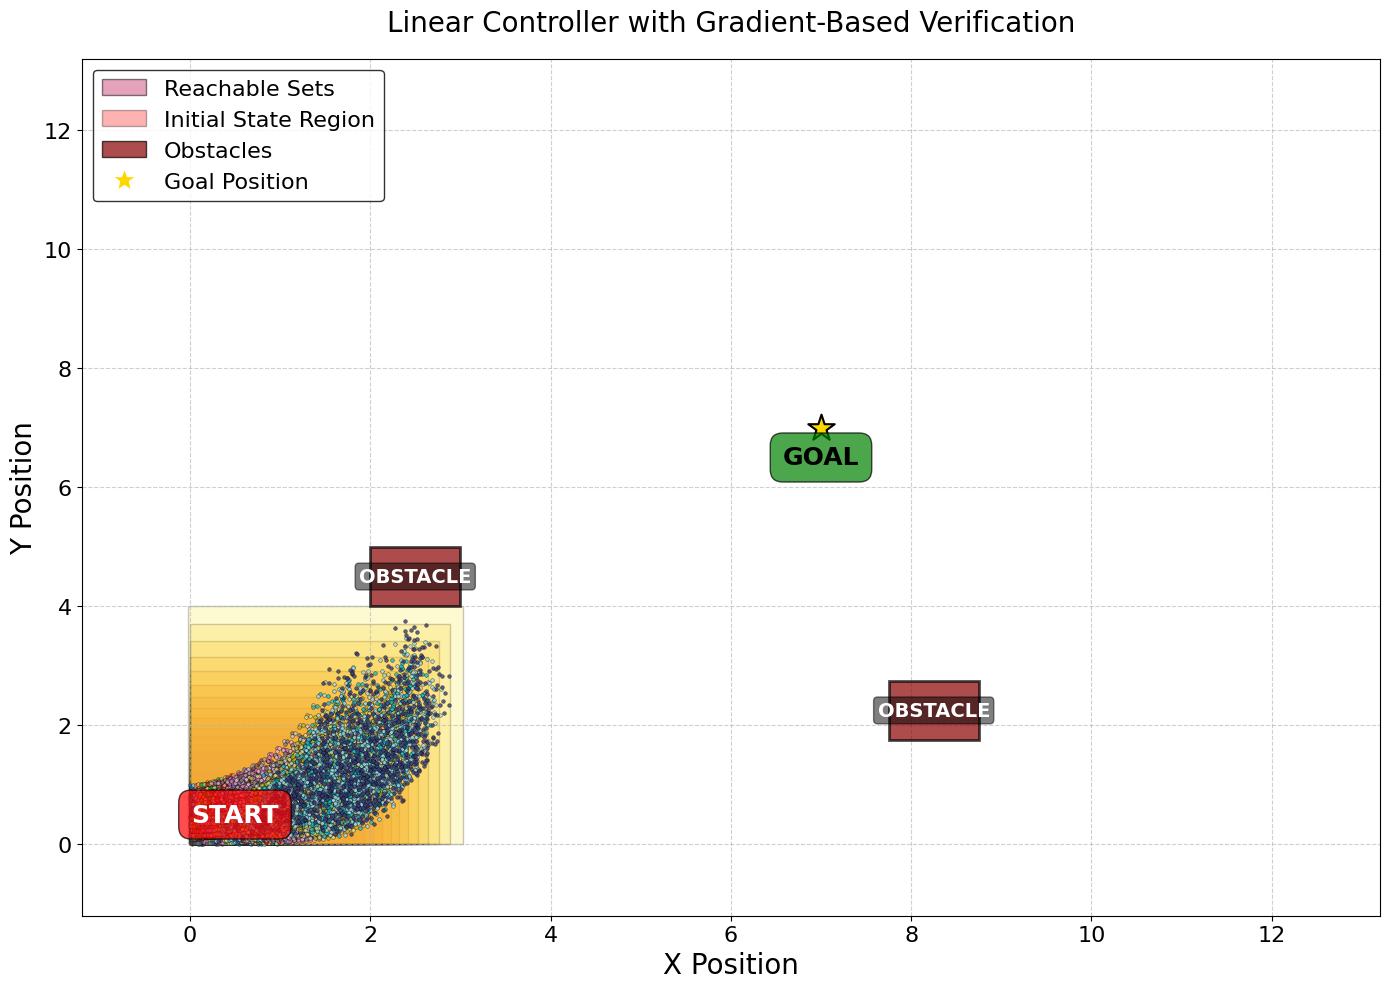


Visualizing neural network controller results...


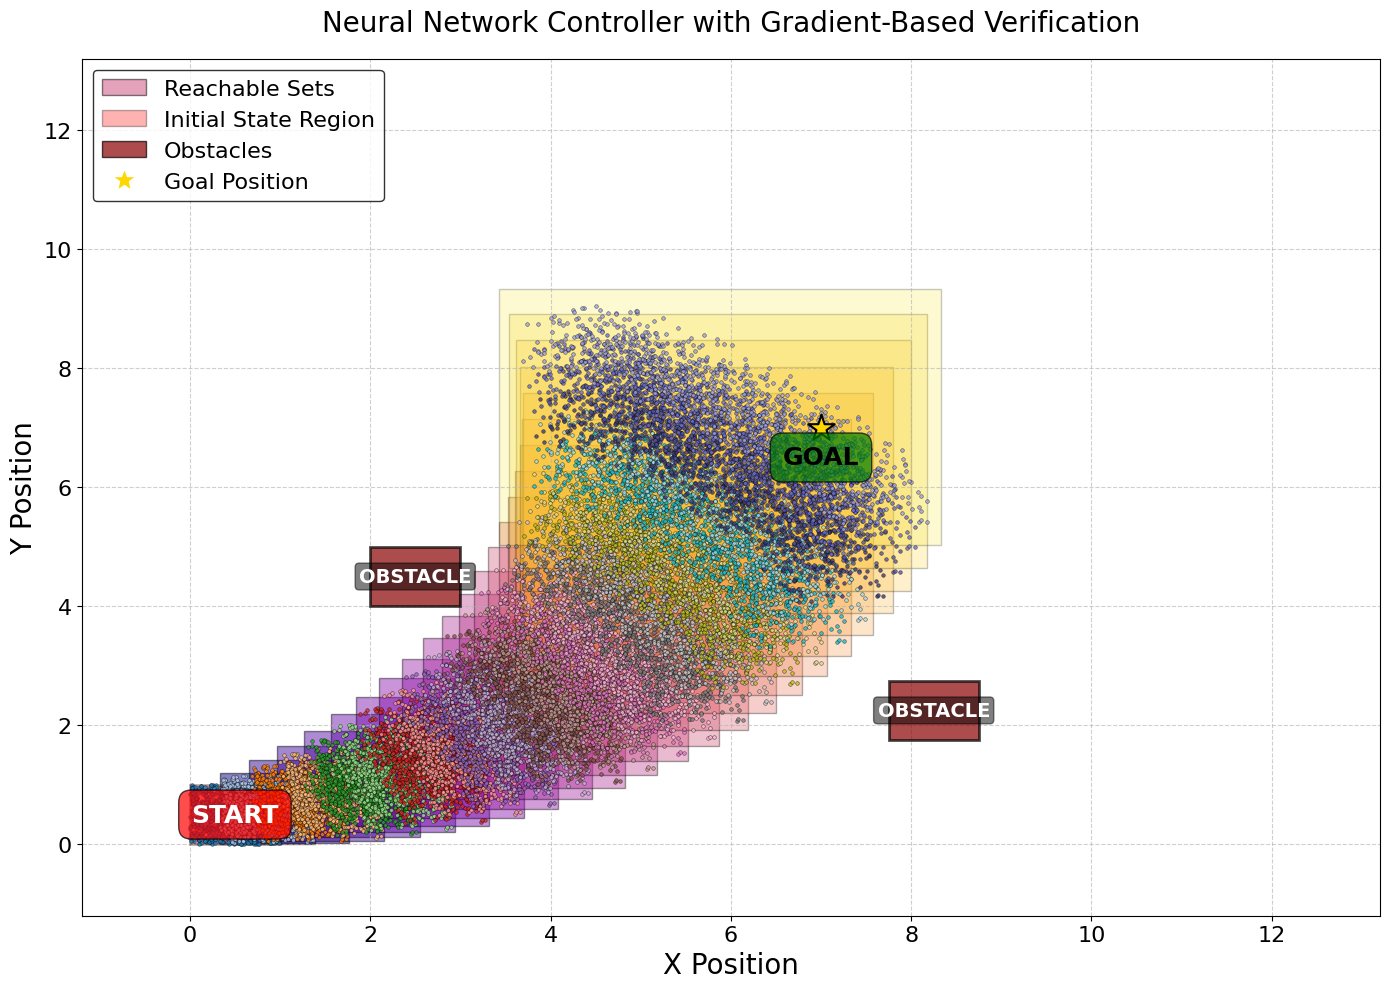

In [24]:
dyn = UnicycleModel()

print("=== Gradient-Based Verification for Unicycle Navigation ===")
print("This notebook implements gradient-based verification techniques")
print("for unicycle navigation with formal safety guarantees.\n")

initial_state_range = np.array([
    [0, 1],       # x position
    [0, 1],       # y position
    [0, np.pi/6]  # theta (orientation)
])

obstacles = [
    [2.0, 4.0, 1.0, 1.0],
    [7.75, 1.75, 1.0, 1.0]
]

grid_size = 13
cost_map = np.zeros((grid_size, grid_size))
goal_zone = (7, 7)
cost_map[goal_zone] = -1

try:
    print("Attempting to load pre-trained controllers...")
    linear_controller = load_controller('gradient_linear.pkl', 'linear')
    nn_controller = load_controller('gradient_nn.pkl', 'neural_network')

    print("Computing reachable sets for loaded controllers...")
    print("Controllers and reachable sets loaded successfully!")

except FileNotFoundError:
    print("Pre-trained controllers not found. Training new controllers...")
    linear_controller, _ = run_linear_experiment()
    nn_controller, _ = run_neural_net_experiment()

print("\nComputing reachable sets for visualization...")
linear_steps = 20
nn_steps = 23

linear_ranges = compute_multistep_reachable_set(
    initial_state_range, linear_controller, linear_steps
)

nn_ranges = compute_multistep_reachable_set(
    initial_state_range, nn_controller, nn_steps
)

print("\nVisualizing linear controller results...")
plot_multistep_samples_and_bounds(
    initial_state_range, linear_controller, linear_steps, cost_map, obstacles,
    bounds_list=linear_ranges,
    title="Linear Controller with Gradient-Based Verification"
)

print("\nVisualizing neural network controller results...")
plot_multistep_samples_and_bounds(
    initial_state_range, nn_controller, nn_steps, cost_map, obstacles,
    bounds_list=nn_ranges,
    title="Neural Network Controller with Gradient-Based Verification"
)